## Neural Style Transfer (A brief guide)

### Problem

Neural Style Transfer is an interesting optimization techniques in deep learning. It merges two images, namely: a **"content" image (C)** as a base image and a **"style" image (S)** of the different picture (usually artistic), to create a **"generated" image (G)**. The generated image G combines the "content" of the image C with the "style" of image S. 

This is achieved through the optimization of a loss function that has 3 components: 

1. **total variation loss** imposes local spatial continuity between the pixels of the combination image, giving it visual coherence.
2. **style loss** is where the deep learning keeps in --that one is defined using a deep convolutional neural network. Precisely, it consists in a sum of L2 distances between the Gram matrices of the representations of the base image and the style reference image, extracted from different layers of a convnet (trained on ImageNet). The general idea is to capture color/texture information at different spatial scales (fairly large scales --defined by the depth of the layer considered).
3. **content loss** is a L2 distance between the features of the base image (extracted from a deep layer) and the features of the combination image, keeping the generated image close enough to the original one.



To do the project faster, I run the code on google colab using a GPU hardware accelerator. 

### 1. Load libraries and images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import PIL
from tensorflow.keras.applications import vgg19
import os
import sys

In [3]:
base_image_path = "/content/drive/MyDrive/Colab Notebooks/content.jpg"
style_image_path = "/content/drive/MyDrive/Colab Notebooks/style.jpg"
result_prefix = "/content/drive/MyDrive/Colab Notebooks/gen_img"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

### 2. Let's take a look at our content image and our style image

In [4]:
from IPython.display import Image, display

Image(filename=base_image_path, width = 180, height = 240)

Output hidden; open in https://colab.research.google.com to view.

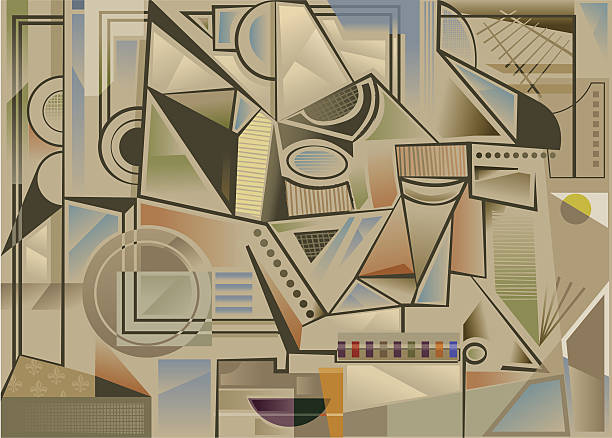

In [5]:
Image(filename=style_image_path, width = 250, height = 200)

### 3. Transform data to use on the model

Define functions to transform the image to a tensor and viceversa.

In [6]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

### 4. Load the VGG19 model

Let's create a feature extraction model that retrieves the intermediate activations of VGG19 (as a dict, by name).

In [7]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

###  5. Compute the style transfer loss

First, we need to define 4 util functions:

- `gram_matrix` (used to compute the style loss)
- The `style_loss` function, which keeps the generated image close to the local textures of the style reference image
- The `content_loss` function, which keeps the high-level representation of the generated image close to that of the base image
- The `total_variation_loss` function, a regularization loss which keeps the generated image locally-coherent

In [8]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

# The style loss is designed to maintain the style of the style image in the generated image.
# It is based on the gram matrices (which capture style) of feature maps from the style image and generated image
def style_loss(style, generated):
    S = gram_matrix(style)
    G = gram_matrix(generated)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - G)) / (4.0 * (channels**2) * (size**2))

# An auxiliary loss function designed to maintain the content of image in the generated image
def content_loss(content, generated):
    return tf.reduce_sum(tf.square(generated - content))

# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    a = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :])
    b = tf.square(x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))


The next step is to compute the sum of the losses (style, content and total variation loss) in `compute_loss` function.

In [9]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"

def compute_loss(generated_image, content_image, style_image):
    input_tensor = tf.concat(
        [content_image, style_image, generated_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    content_image_features = layer_features[0, :, :, :]
    generated_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        content_image_features, generated_features)
    
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        generated_features = layer_features[2, :, :, :]
        sl = style_loss(style_features, generated_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(generated_image)
    return loss

### 6. Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.

In [10]:
@tf.function
def compute_loss_and_grads(generated_image, content_image, style_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(generated_image, content_image, style_image)
    grads = tape.gradient(loss, generated_image)
    return loss, grads


### 7. The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps. 

In [11]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

content_image = preprocess_image(base_image_path)
style_image = preprocess_image(style_image_path)
generated_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(generated_image, content_image, style_image)
    optimizer.apply_gradients([(grads, generated_image)])
    print(".", end='', flush=True)

    if i % 100 == 0:
        print("Train step %d" % i)
        img = deprocess_image(generated_image.numpy())
        fname = result_prefix + "_iter_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

....................................................................................................Train step 100
....................................................................................................Train step 200
....................................................................................................Train step 300
....................................................................................................Train step 400
....................................................................................................Train step 500
....................................................................................................Train step 600
....................................................................................................Train step 700
....................................................................................................Train step 800
................................................................................

### 8. Check the generated image

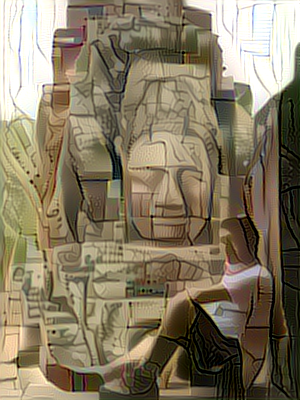

In [12]:
gen_image_path = result_prefix + "_iter_4000.png"
Image(filename=gen_image_path, width = 180, height = 240)

# A faster way: Use Tensorflow Lite

In [13]:
import tensorflow_hub as hub

In [14]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [15]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)    

In [16]:
content_image = load_img(base_image_path)
style_image = load_img(style_image_path)
generated_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

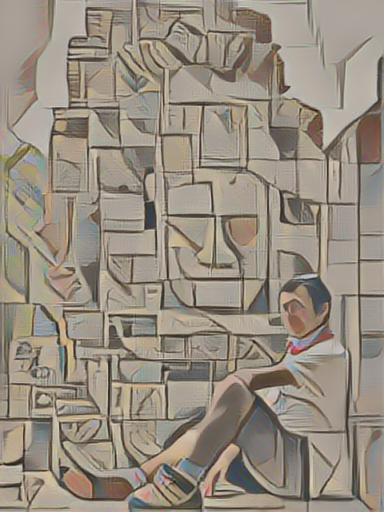

In [18]:
tensor_to_image(generated_image).save('/content/drive/MyDrive/Colab Notebooks/gen_img_tsLite.png')
tensor_to_image(generated_image)